# Evaluation Script Test 

In [1]:
using AutomotiveDrivingModels, AutoViz, Reel

Load models and config

In [2]:
include("eval-env/occluded_crosswalk.jl") # env config

CrosswalkEnv

In [3]:
include("eval-env/constant_pedestrian.jl") # pedestrian model

In [4]:
include("eval-env/pedestrian_flow.jl")

initial_pedestrian

In [5]:
include("render_helpers.jl")

animate_record (generic function with 1 method)

In [6]:
include("eval-env/simple_sensor.jl")

is_observable

In [7]:
include("eval-env/ego_control.jl")

initial_ego

In [8]:
include("simulation.jl")

In [9]:
include("eval_config.jl") # eval config

is_terminal (generic function with 1 method)

## Initialize 

### Configure the Evaluation
- Time step
- Number of episodes 
- ...

In [10]:
config = EvalConfig() # use default

EvalConfig(0.1,MersenneTwister(UInt32[0x00000003],Base.dSFMT.DSFMT_state(Int32[-1359582567,1073454075,1934390716,1073583786,-114685834,1073112842,-1913218479,1073122729,-73577195,1073266439  …  1226759590,1072980451,-1366384707,1073012992,1661148031,2121090155,141576524,-658637225,382,0]),[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],382),1,200,(AutomotiveDrivingModels.CollisionCallback
  mem: AutomotiveDrivingModels.CPAMemory
,TerminalCallback()))

In [11]:
cam = FitToContentCamera(0.0)

AutoViz.FitToContentCamera(0.0)

### Configure the Environment

In [12]:
params = EnvParams(ped_rate = 0.5)
env = CrosswalkEnv(params)

CrosswalkEnv(Roadway,AutomotiveDrivingModels.Lane(LaneTag(1, 1),AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN),CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)],6.0,AutomotiveDrivingModels.SpeedLimit(-Inf,Inf),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneConnection[],AutomotiveDrivingModels.LaneConnection[]),AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(22.000, -4.500)
	VecE2(22.000, -1.500)
],EnvParams(2,50.0,3.0,20.0,6.0,5.0,37.0,8.0,0.5,2.0,10.0))

In [13]:
sensor = SimpleSensor(0.1, 0.1)

SimpleSensor(0.1,0.1)

## Initialize states

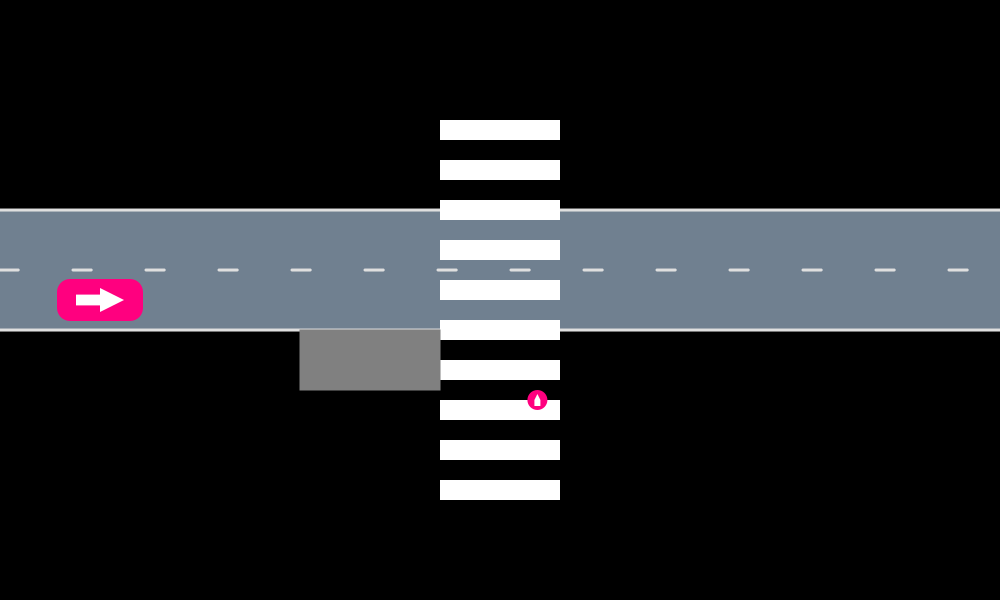

In [14]:
# Car definition
ego_initial_state = VehicleState(VecSE2(5.0, 0., 0.), env.roadway.segments[1].lanes[1],env.roadway, 8.0)
ego = Vehicle(ego_initial_state, VehicleDef(), 1)

scene = Scene()
push!(scene, ego)

ped = initial_pedestrian(env, config.rng)
push!(scene, ped)

# visualize the initial state
render(scene, env, cam=cam)

## Test with baseline policy

In [15]:
include("baseline_policy.jl")

update

In [48]:
ego = initial_ego(env, config.rng)
policy = waitAndGo(env, ego, 2.0, -4.0, config.sim_dt, 4, 2.5, true, false, false, 0);
updater = waitAndGoUpdater(policy)

waitAndGoUpdater(waitAndGo(CrosswalkEnv(Roadway,AutomotiveDrivingModels.Lane(LaneTag(1, 1),AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN),CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)],6.0,AutomotiveDrivingModels.SpeedLimit(-Inf,Inf),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneConnection[],AutomotiveDrivingModels.LaneConnection[]),AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(22.000, -4.500)
	VecE2(22.000, -1.500)
],EnvParams(2,50.0,3.0,20.0,6.0,5.0,37.0,8.0,0.5,2.0,10.0)),Vehicle(1, VehicleState(VecSE2({5.000, 0.000}, 0.000), Frenet(RoadIndex({1, 0.100000}, {1, 1}), 5.000, 0.000, 0.000), 7.255), VehicleDef(CAR, 4.000, 1.800)),2.0,-4.0,0.1,4,2.5,true,false,false,0))

In [49]:
scene = Scene()
push!(scene, ego);

In [50]:
models = Dict{Int, DriverModel}()
# Constant speed model
models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 
models[2] = ConstantPedestrian(0.1, 0.5, 2.0, config.sim_dt)

ConstantPedestrian(0.1,0.5,2.0,0.1)

In [51]:
nticks = 70
rec = SceneRecord(nticks+1, config.sim_dt)
# execute the simulation
@time simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)

  0.003055 seconds (5.93 k allocations: 347.773 KB)


SceneRecord(nscenes=71)

In [52]:
duration, fps, render_rec = animate_record(rec)
film = roll(render_rec, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_AE2F.tmp",0x0000000000000047,10.0,nothing)

## Evaluate and tune the baseline

The parameters we wish to tune are the TTC threshold and the number of redundancy

In [61]:
# initialize policy to evaluate
policy = waitAndGo(env, ego, 2.0, -4.0, config.sim_dt, 1, 2., true, false, false, 0);
updater = waitAndGoUpdater(policy)

models = Dict{Int, DriverModel}()
# Constant speed model
models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 

#evaluation 
config.n_episodes = 100
nticks = config.time_out
rec = SceneRecord(nticks+1, config.sim_dt)

# intiialize containers and callbacks
time_outs = 0
crashes = 0
successes = 0
steps = zeros(config.n_episodes)


for ep = 1:config.n_episodes
    
    # initialize scene
    ego = initial_ego(env, config.rng)
    scene = Scene()
    push!(scene, ego);

        
    simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)
 
    # analyze
    if rec.nframes == config.time_out 
        time_outs += 1
    elseif !is_collision_free(rec[0])
        crashes += 1
    elseif is_terminal(rec[0], env)
        successes += 1
    end
    
    steps[ep] = nframes(rec)       
        
end
@assert time_outs + crashes + successes == config.n_episodes 
    